# Task
Implement an AI-Based Disaster Detection and Rescue Support system using the C2A dataset. The system detect multiple natural disasters (floods, earthquakes, tsunamis, fires) and the number of people stuck, and based on this information, provide support team recommendations to enhance disaster response efficiency and support affected communities. The system quickly identifies disaster events and suggests appropriate emergency resources like rescue teams, medical aid, shelters, food, and evacuation plans. The goal is to enhance disaster response efficiency, reduce harm, and support affected communities in recovery through timely, tailored resource recommendations." The dataset is located at "/content/drive/MyDrive/C2A.zip".

## Setup environment and mount drive

### Subtask:
Install necessary libraries and mount Google Drive to access the dataset.


In [ ]:
!pip install ultralytics
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


## Load and extract dataset

### Subtask:
Load the zipped C2A dataset from Google Drive and extract its contents to a local directory.


In [ ]:
import zipfile
import os

# Define the corrected path to the zipped dataset in Google Drive
zip_path = '/content/drive/MyDrive/archive (2).zip'

# Define the path to the local directory where the dataset will be extracted
extract_path = '/content/c2a_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Use the zipfile module to open and extract the contents of the zipped dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: /content/c2a_dataset


## Data preparation and preprocessing for human detection

### Subtask:
Define the classes for object detection (initially 'human'), organize the extracted image and annotation files, convert annotations to the YOLO format, split the dataset into training and validation sets, and prepare data loaders for the YOLO model.


In [ ]:
# List the contents of the extracted dataset directory
!ls /content/c2a_dataset/C2A_Dataset/new_dataset3/

# List the contents of the train and val directories to see the image and label files
!ls /content/c2a_dataset/C2A_Dataset/new_dataset3/train/
!ls /content/c2a_dataset/C2A_Dataset/new_dataset3/val/

'All labels with Pose information'   test   train   val
images	labels	train_annotations.json
images	labels	val_annotations.json


In [ ]:
import json
import os

def coco_to_yolo(coco_bbox, image_width, image_height):
    """Converts COCO bounding box [x_min, y_min, width, height] to YOLO format [x_center, y_center, width, height]."""
    x_min, y_min, width, height = coco_bbox
    x_center = (x_min + width / 2) / image_width
    y_center = (y_min + height / 2) / image_height
    w_norm = width / image_width
    h_norm = height / image_height
    return [x_center, y_center, w_norm, h_norm]

def convert_annotations(json_path, image_dir, output_label_dir):
    """Converts COCO annotations in a JSON file to YOLO format .txt files."""
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Create output directory if it doesn't exist
    os.makedirs(output_label_dir, exist_ok=True)

    # Create a dictionary to map image_id to image information (including width and height)
    image_info = {img['id']: (img['width'], img['height'], img['file_name']) for img in coco_data['images']}

    # Create a dictionary to store annotations per image
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Process annotations for each image
    for image_id, annotations in annotations_by_image.items():
        img_width, img_height, file_name = image_info[image_id]
        # YOLO label file name should match the image file name (but with .txt extension)
        label_file_name = os.path.splitext(file_name)[0] + '.txt'
        label_file_path = os.path.join(output_label_dir, label_file_name)

        with open(label_file_path, 'w') as f:
            for ann in annotations:
                # Assuming 'human' is category_id 0 as observed in the sample annotation
                category_id = ann['category_id'] # This should be 0 for 'human'
                yolo_bbox = coco_to_yolo(ann['bbox'], img_width, img_height)
                # Write the YOLO format: class_index center_x center_y width height
                f.write(f"{category_id} {yolo_bbox[0]:.6f} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f}\n")

    print(f"Converted annotations from {json_path} to YOLO format in {output_label_dir}")

# Define paths
base_dataset_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3'
train_json_path = os.path.join(base_dataset_path, 'train', 'train_annotations.json')
val_json_path = os.path.join(base_dataset_path, 'val', 'val_annotations.json')

train_image_dir = os.path.join(base_dataset_path, 'train', 'images')
val_image_dir = os.path.join(base_dataset_path, 'val', 'images')

train_label_dir = os.path.join(base_dataset_path, 'train', 'labels')
val_label_dir = os.path.join(base_dataset_path, 'val', 'labels')

# Convert train and validation annotations
convert_annotations(train_json_path, train_image_dir, train_label_dir)
convert_annotations(val_json_path, val_image_dir, val_label_dir)

# Verify a few created label files
print("\nVerifying generated label files for training:")
!ls {train_label_dir} | head -n 5
print("\nVerifying generated label files for validation:")
!ls {val_label_dir} | head -n 5

Converted annotations from /content/c2a_dataset/C2A_Dataset/new_dataset3/train/train_annotations.json to YOLO format in /content/c2a_dataset/C2A_Dataset/new_dataset3/train/labels
Converted annotations from /content/c2a_dataset/C2A_Dataset/new_dataset3/val/val_annotations.json to YOLO format in /content/c2a_dataset/C2A_Dataset/new_dataset3/val/labels

Verifying generated label files for training:
collapsed_building_image0001_0.txt
collapsed_building_image0001_1.txt
collapsed_building_image0001_2.txt
collapsed_building_image0001_4.txt
collapsed_building_image0002_0.txt

Verifying generated label files for validation:
collapsed_building_image0003_1.txt
collapsed_building_image0005_0.txt
collapsed_building_image0006_0.txt
collapsed_building_image0006_2.txt
collapsed_building_image0006_3.txt


In [ ]:
#Create the `data.yaml` configuration file required by YOLO, specifying the paths to the training and validation image and label directories,
#the number of classes, and the class names.


import yaml

# Define the content of the data.yaml file
data_yaml_content = {
    'train': os.path.join(base_dataset_path, 'train', 'images'), # Path to training images
    'val': os.path.join(base_dataset_path, 'val', 'images'),     # Path to validation images
    'nc': 1,                                                     # Number of classes
    'names': ['human']                                           # Class names
}

# Define the path where the data.yaml file will be saved
data_yaml_path = os.path.join(base_dataset_path, 'data.yaml')

# Write the content to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_yaml_content, f, default_flow_style=None)

print(f"Created data.yaml file at: {data_yaml_path}")

# Display the content of the created data.yaml file
with open(data_yaml_path, 'r') as f:
    print("\nContent of data.yaml:")
    print(f.read())

Created data.yaml file at: /content/c2a_dataset/C2A_Dataset/new_dataset3/data.yaml

Content of data.yaml:
names: [human]
nc: 1
train: /content/c2a_dataset/C2A_Dataset/new_dataset3/train/images
val: /content/c2a_dataset/C2A_Dataset/new_dataset3/val/images



## Model building and Training: human detection

### Subtask:
 Add YOLO model architecture (e.g., YOLOv8) and initialize the YOLO model, potentially using pre-trained weights.


In [ ]:
from ultralytics import YOLO

# Use a YOLOv8 model architecture
model_architecture = 'yolov8n.pt'

# Instantiate the YOLO model
model = YOLO(model_architecture)

# Print the model to inspect its layers
#print(model)
results = model.train(data=data_yaml_path, epochs=1, batch=32)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/c2a_dataset/C2A_Dataset/new_dataset3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2081.2±555.4 MB/s, size: 3085.1 KB)


train: Scanning /content/c2a_dataset/C2A_Dataset/new_dataset3/train/labels... 6129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6129/6129 [00:05<00:00, 1136.06it/s]

train: /content/c2a_dataset/C2A_Dataset/new_dataset3/train/images/flood_image0407_3.png: 1 duplicate labels removed


train: New cache created: /content/c2a_dataset/C2A_Dataset/new_dataset3/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2266.7±1065.8 MB/s, size: 321.9 KB)


val: Scanning /content/c2a_dataset/C2A_Dataset/new_dataset3/val/labels... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:01<00:00, 1076.95it/s]

val: New cache created: /content/c2a_dataset/C2A_Dataset/new_dataset3/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.677      1.478      1.073        649        640: 100%|██████████| 192/192 [30:15<00:00,  9.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [05:01<00:00,  9.41s/it]


                   all       2043      72123      0.727      0.551      0.594      0.315

1 epochs completed in 0.589 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:51<00:00,  7.22s/it]


                   all       2043      72123      0.726      0.551      0.593      0.315
Speed: 2.1ms preprocess, 74.1ms inference, 0.0ms loss, 19.1ms postprocess per image
Results saved to runs/detect/train


##Model Evaluation : Human detection

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

val: Scanning /content/c2a_dataset/C2A_Dataset/new_dataset3/val/labels.cache... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [03:10<00:00,  2.97s/it]


                   all       2043      72123      0.725      0.552      0.593      0.315
Speed: 0.6ms preprocess, 54.4ms inference, 0.0ms loss, 19.6ms postprocess per image
Results saved to runs/detect/train2


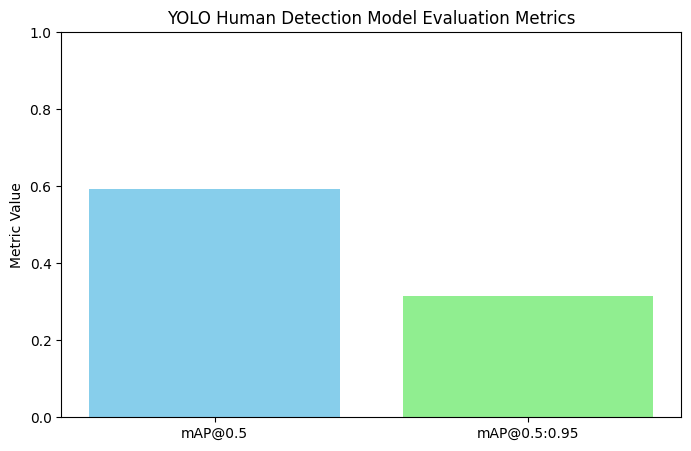

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print(model)
print("Evaluating Human Detection Model...")

yolo_results = model.val(data=data_yaml_path) # Reverted to using data_yaml_path

mAP50 = yolo_results.results_dict.get('metrics/mAP50(B)', 'N/A')
mAP50_95 = yolo_results.results_dict.get('metrics/mAP50-95(B)', 'N/A')

# Plotting the evaluation metrics
metrics = ['mAP@0.5', 'mAP@0.5:0.95']
values = [mAP50, mAP50_95]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'lightgreen'])
plt.ylabel('Metric Value')
plt.title('YOLO Human Detection Model Evaluation Metrics')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.show()

## Haar Cascade MODEL : Human Detection

In [ ]:
import cv2
import os
import numpy as np # Import numpy

# Load the pre-trained Haar Cascade classifier for full body detection
# Attempt to find the cascade file
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_fullbody.xml' # Corrected typo here

if not os.path.exists(haar_cascade_path):
    print(f"Error: Haar Cascade file not found at {haar_cascade_path}")
    print("Please ensure 'haarcascade_fullbody.xml' is available in your OpenCV data directory.")
    haar_fullbody = None
else:
    haar_fullbody = cv2.CascadeClassifier(haar_cascade_path)
    print(f"Successfully loaded Haar Cascade classifier from {haar_cascade_path}")


class HaarCascadeHumanDetector:
    """
    A wrapper class for the Haar Cascade human detection function to mimic a model interface.
    """
    def __init__(self, cascade_classifier):
        self.cascade_classifier = cascade_classifier
        if self.cascade_classifier is None:
            print("Warning: Haar Cascade classifier not loaded. Detection will not work.")

    def __call__(self, image_path):

        dummy_boxes = [] # To mimic YOLO results structure

        if self.cascade_classifier is None:
            print("Haar Cascade classifier not loaded.")
            return [DummyResult([])] # Return DummyResult with empty boxes if classifier not loaded

        img = cv2.imread(image_path)

        if img is None:
            print(f"Error: Could not load image from {image_path}")
            return [DummyResult([])] # Return DummyResult with empty boxes if image not loaded

        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect full bodies in the image
        bodies = self.cascade_classifier.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Process the detected bodies
        for (x, y, w, h) in bodies:
            # Add to dummy_boxes for compatibility, assuming class 0 for human
            # Format: [x1, y1, x2, y2, conf, class]
            dummy_boxes.append([int(x), int(y), int(x+w), int(y+h), 1.0, 0])

        # Wrap dummy_boxes in an object with a 'xyxy' attribute
        class DummyBoxes:
            def __init__(self, boxes_list):
                # Handle empty list case to avoid IndexError
                if not boxes_list:
                    self.xyxy = np.empty((0, 6)) # Create an empty 2D array with 6 columns
                else:
                    self.xyxy = np.array(boxes_list)

                # Ensure conf and cls attributes are created even if xyxy is empty
                self.conf = self.xyxy[:, 4] if self.xyxy.size > 0 else np.array([])
                self.cls = self.xyxy[:, 5] if self.xyxy.size > 0 else np.array([])


        # Return results in a list containing an object that mimics YOLO results structure
        class DummyResult:
            def __init__(self, boxes):
                self.boxes = DummyBoxes(boxes)

        return [DummyResult(dummy_boxes)]


# Instantiate the Haar Cascade detector
haar_detector = HaarCascadeHumanDetector(haar_fullbody)

# Example usage (you can now use haar_detector like the YOLO model object)
test_image_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images/fire_image0094_2.png'
if os.path.exists(test_image_path) and haar_detector.cascade_classifier is not None:
  haar_results = haar_detector(test_image_path)
  print(f"\nHaar Cascade Detection Results for {os.path.basename(test_image_path)}:")
  if haar_results and haar_results[0].boxes.xyxy.size > 0:
    print(f" Detected Humans: {len(haar_results[0].boxes.xyxy)}")
    print(f" Detection Details (mimicking YOLO format): {haar_results[0].boxes.xyxy}") # Uncomment for details
  else:
    print(" No humans detected.")
else:
  print(f"Test image not found at {test_image_path} or Haar Cascade not loaded.")

Successfully loaded Haar Cascade classifier from /usr/local/lib/python3.11/dist-packages/cv2/data/haarcascade_fullbody.xml

Haar Cascade Detection Results for fire_image0094_2.png:
 No humans detected.



Evaluating detector on 2043 images...

Haar Cascade Human Detection Evaluation Results:
{
  "Precision": 0.07017543798091722,
  "Recall": 0.0001109216200087223,
  "F1-Score": 0.00022148998937676455,
  "TP": 8,
  "FP": 106,
  "FN": 72115
}


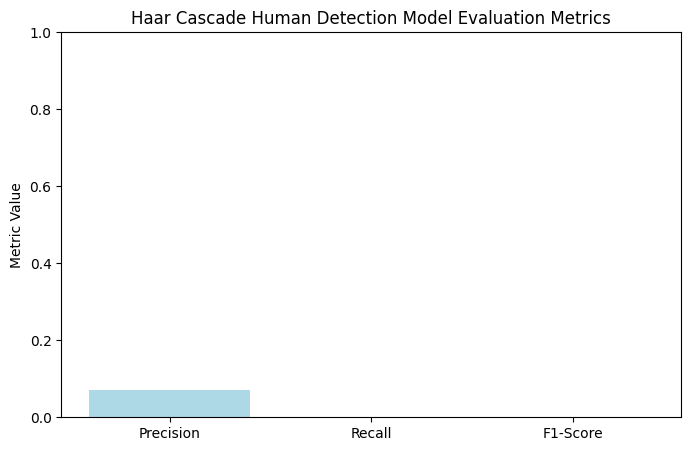

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import json # Import json
def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes."""
    # box1 and box2 are [x_min, y_min, x_max, y_max]
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Determine the coordinates of the intersection rectangle
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2) # Corrected typo here
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)

    # Compute the area of intersection rectangle
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    # Compute the intersection over union by dividing the intersection area by the union area
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / (union_area + 1e-6) # Add a small epsilon to avoid division by zero

    return iou


def evaluate_detector(detector, image_dir, label_dir, iou_threshold=0.5):

    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

    print(f"\nEvaluating detector on {len(image_files)} images...")

    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        label_filename = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_filename)

        # Get ground truth bounding boxes from YOLO format labels
        ground_truth_boxes = []
        if os.path.exists(label_path):
            img = cv2.imread(img_path)
            if img is not None:
                img_height, img_width, _ = img.shape
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5 and int(parts[0]) == 0: # human class ID is 0
                            # Convert YOLO format to [x_min, y_min, x_max, y_max]
                            x_center, y_center, width, height = map(float, parts[1:])
                            x_min = int((x_center - width / 2) * img_width)
                            y_min = int((y_center - height / 2) * img_height)
                            x_max = int((x_center + width / 2) * img_width)
                            y_max = int((y_center + height / 2) * img_height)
                            ground_truth_boxes.append([x_min, y_min, x_max, y_max])
            else:
                print(f"Warning: Could not read image {image_file} to get dimensions for label conversion.")

        # Get predicted bounding boxes from the detector
        predicted_detections = detector(img_path)
        predicted_boxes = []
        if predicted_detections and predicted_detections[0].boxes.xyxy.size > 0:
             # Extract bounding boxes from the dummy result structure
             predicted_boxes = predicted_detections[0].boxes.xyxy[:, :4].astype(int).tolist()

        image_true_positives = 0
        image_false_positives = 0
        image_false_negatives = 0

        # Keep track of matched ground truth boxes to avoid double counting
        matched_gt_indices = set()

        for p_box in predicted_boxes:
            is_matched = False
            for gt_idx, gt_box in enumerate(ground_truth_boxes):
                if gt_idx not in matched_gt_indices and calculate_iou(p_box, gt_box) >= iou_threshold:
                    image_true_positives += 1
                    matched_gt_indices.add(gt_idx)
                    is_matched = True
                    break # Move to the next predicted box

            if not is_matched:
                image_false_positives += 1

        image_false_negatives = len(ground_truth_boxes) - len(matched_gt_indices)

        total_true_positives += image_true_positives
        total_false_positives += image_false_positives
        total_false_negatives += image_false_negatives


    # Calculate overall metrics
    precision = total_true_positives / (total_true_positives + total_false_positives + 1e-6)
    recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'TP': total_true_positives,
        'FP': total_false_positives,
        'FN': total_false_negatives
    }

# --- Perform Evaluation ---
# Ensure haar_detector is initialized
if 'haar_detector' not in globals() or haar_detector.cascade_classifier is None:
    print("Haar Cascade detector not initialized or loaded properly. Cannot perform evaluation.")
    haar_eval_metrics = None
else:
    haar_eval_metrics = evaluate_detector(haar_detector, val_image_dir, val_label_dir, iou_threshold=0.5)


# --- Plot Evaluation Metrics ---
if haar_eval_metrics:
    print("\nHaar Cascade Human Detection Evaluation Results:")
    print(json.dumps(haar_eval_metrics, indent=2))

    metrics = ['Precision', 'Recall', 'F1-Score']
    values = [haar_eval_metrics[metric] for metric in metrics]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values, color=['lightblue', 'lightcoral', 'lightgreen'])
    plt.ylabel('Metric Value')
    plt.title('Haar Cascade Human Detection Model Evaluation Metrics')
    plt.ylim(0, 1) # Metrics are typically between 0 and 1
    plt.show()
else:
    print("\nHaar Cascade evaluation could not be performed.")

## Data preparation and preprocessing for disaster type classification

### Subtask:
Infer disaster types from image filenames or directory structure, define the classes for image classification based on inferred types, organize images into class-specific subfolders for training and validation, and prepare data loaders for the image classification model, including necessary preprocessing steps like resizing and normalization.


In [ ]:
!pip install tensorflow
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define base paths
base_dataset_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3'
train_base_path = os.path.join(base_dataset_path, 'train')
val_base_path = os.path.join(base_dataset_path, 'val')

# Define disaster types (still based on the expected filenames)
disaster_types = ['collapsed_building', 'flood', 'fire', 'traffic_incident']
print(f"Using disaster types for classification: {disaster_types}")

# Re-create directories to ensure a clean state before moving
for dtype in disaster_types:
    train_dir = os.path.join(train_base_path, dtype)
    val_dir = os.path.join(val_base_path, dtype)
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    print(f"Cleaned and re-created directories for {dtype} in train and val.")


# Function to move images based on filename string matching
def organize_images_by_filename_match(src_image_dir, dest_base_dir, disaster_types_list):
    moved_count = 0
    for filename in os.listdir(src_image_dir):
        src_path = os.path.join(src_image_dir, filename)
        if os.path.isfile(src_path):
            moved = False
            for dtype in disaster_types_list:
                if dtype in filename: # Check if the disaster type string is in the filename
                    dest_dir = os.path.join(dest_base_dir, dtype)
                    dest_path = os.path.join(dest_dir, filename)
                    try:
                        shutil.move(src_path, dest_path)
                        moved_count += 1
                        # print(f"Moved {filename} to {dest_dir}")
                        moved = True
                        break
                    except Exception as e:
                        print(f"Error moving {filename} to {dest_dir}: {e}")
                        moved = True # Treat as moved to avoid "not moved" warning if error occurs after finding type
                        break # Stop searching for type if a match is found

            if not moved:
                print(f"Warning: Could not determine disaster type from filename: {filename}. Leaving in original location.")
    print(f"Successfully moved {moved_count} images from {src_image_dir}")


train_image_dir_original = os.path.join(train_base_path, 'images')
val_image_dir_original = os.path.join(val_base_path, 'images')

print("\nOrganizing training images based on filename...")
organize_images_by_filename_match(train_image_dir_original, train_base_path, disaster_types)

print("\nOrganizing validation images based on filename...")
organize_images_by_filename_match(val_image_dir_original, val_base_path, disaster_types)


# 4. Verify the organization by listing contents
print("\nVerifying organization after filename-based move:")
for dtype in disaster_types:
    print(f"\nContents of train/{dtype} (first 5):")
    !ls {os.path.join(train_base_path, dtype)} | head -n 5
    print(f"Contents of val/{dtype} (first 5):")
    !ls {os.path.join(val_base_path, dtype)} | head -n 5


print(f"\nContents of original train/images (first 5):")
!ls {train_image_dir_original} | head -n 5
print(f"Contents of original val/images (first 5):")
!ls {val_image_dir_original} | head -n 5


# Prepare data loaders for image classification
image_size = (224, 224) # Define image_size here
batch_size = 32 # Define batch_size here
img_height, img_width = image_size # Use the previously defined image size (224, 224)
batch_size_val = batch_size # Use the previously defined batch size (32)

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Add other augmentation parameters if needed, e.g., rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

# Only normalization for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_base_path, # Point to the base train directory containing class subfolders
    target_size=(img_height, img_width),
    batch_size=batch_size_val,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    classes=disaster_types # Explicitly set classes to ensure order and mapping
)

val_generator = val_datagen.flow_from_directory(
    val_base_path, # Point to the base val directory containing class subfolders
    target_size=(img_height, img_width),
    batch_size=batch_size_val,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    classes=disaster_types # Explicitly set classes to ensure order and mapping
)

print("\nTraining and validation data generators created.")
print(f"Training classes: {train_generator.class_indices}")
print(f"Validation classes: {val_generator.class_indices}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


Using disaster types for classification: ['collapsed_building', 'flood', 'fire', 'traffic_incident']
Cleaned and re-created directories for collapsed_building in train and val.
Cleaned and re-created directories for flood in train and val.
Cleaned and re-created directories for fire in train and val.
Cleaned and re-created directories for traffic_incident in train and val.

Organizing training images based on filename...
Successfully moved 6129 images from /content/c2a_dataset/C2A_Dataset/new_dataset3/train/images

Organizing validation images based on filename...
Successfully moved 2043 images from /content/c2a_dataset/C2A_Dataset/new_dataset3/val/images

Verifying organization after filename-based move:

Contents of train/collapsed_building (first 5):
collapsed_building_image0001_0.png
collapsed_building_image0001_1.png
collapsed_building_image0001_2.png
collapsed_building_image0001_4.png
collapsed_building_image0002_0.png
Contents of val/collapsed_building (first 5):
collapsed_build

## Model building and Training: disaster type classification

### Subtask:
Choose a suitable image classification model architecture (e.g., a pre-trained model like ResNet or EfficientNet for transfer learning), load the pre-trained weights, and modify the final layers for the specific number of disaster classes.


In [ ]:

# Create the model before compiling and training
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2


# Define the base pre-trained model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new Keras Functional API model on top of the frozen base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a final dense layer with num_classes units and softmax activation
num_classes = len(disaster_types)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_classification = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model_classification.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Train the model

num_epochs = 5
history = model_classification.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator
)

print("\nImage classification model training complete.")

Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1293s 7s/step - accuracy: 0.7499 - loss: 0.6149 - val_accuracy: 0.9535 - val_loss: 0.1535
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1280s 7s/step - accuracy: 0.9625 - loss: 0.1361 - val_accuracy: 0.9677 - val_loss: 0.1036
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1273s 7s/step - accuracy: 0.9775 - loss: 0.0875 - val_accuracy: 0.9780 - val_loss: 0.0805
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1276s 7s/step - accuracy: 0.9853 - loss: 0.0614 - val_accuracy: 0.9824 - val_loss: 0.0670
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 1285s 7s/step - accuracy: 0.9926 - loss: 0.0429 - val_accuracy: 0.9819 - val_loss: 0.0649

Image classification model training complete.


## Model Evaluation:disaster type classification



64/64 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.9889 - loss: 0.0537

 Disaster Type Classification Model Evaluation Complete!
 Classification Evaluation Metrics:
  Validation Loss: 0.0649
  Validation Accuracy: 0.9819


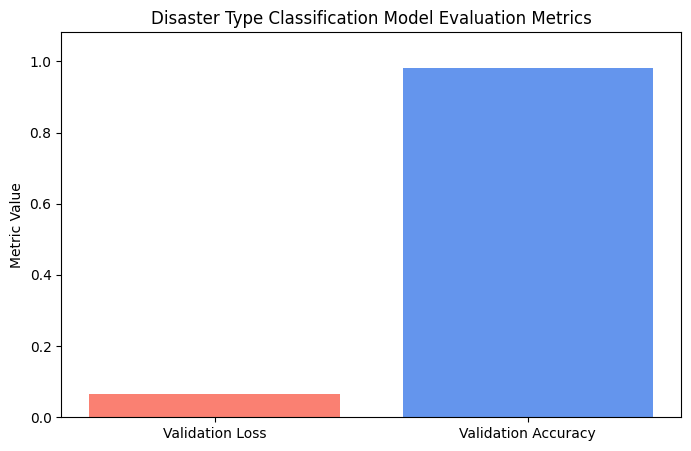

In [ ]:
import matplotlib.pyplot as plt

loss, accuracy = model_classification.evaluate(val_generator)

# Print classification evaluation metrics
print("\n Disaster Type Classification Model Evaluation Complete!")
print(" Classification Evaluation Metrics:")
print(f"  Validation Loss: {loss:.4f}")
print(f"  Validation Accuracy: {accuracy:.4f}")

# Plotting the evaluation metrics
metrics = ['Validation Loss', 'Validation Accuracy']
values = [loss, accuracy]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['salmon', 'cornflowerblue'])
plt.ylabel('Metric Value')
plt.title('Disaster Type Classification Model Evaluation Metrics')

plt.ylim(0, max(loss, accuracy) + 0.1)
plt.show()

## Model Integration and Resource Recommendation Logic
Integrate the two trained models (human detection and disaster type classification). Develop logic to analyze an image using both models and recommend appropriate emergency resources based on the detected human count and the classified disaster type.

In [6]:
import os
import base64
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input

# Define your resource recommendations dictionary (copy as-is)
RESCUE_RESOURCES = {
    'collapsed_building': {
        'no_humans': ['Search and rescue dogs', 'Structural assessment team', 'Heavy equipment'],
        'low_density': ['Ground rescue teams (small)', 'Medical aid (basic)', 'Search and rescue dogs'],
        'medium_density': ['Ground rescue teams (multiple)', 'Medical aid (advanced)', 'Temporary shelter assessment'],
        'high_density': ['Multiple rescue teams (heavy urban search and rescue)', 'Medical triage setup', 'Temporary shelters', 'Food and water supplies']
    },
    'flood': {
        'no_humans': ['Flood damage assessment', 'Infrastructure check'],
        'low_density': ['Water rescue team (small boat)', 'Medical aid (basic)', 'Evacuation route assessment'],
        'medium_density': ['Water rescue teams (multiple boats)', 'Medical aid (advanced)', 'Evacuation support', 'Temporary shelters'],
        'high_density': ['Multiple water rescue teams (boats/helicopters)', 'Medical triage setup', 'Temporary shelters', 'Food and water supplies', 'Evacuation plans']
    },
    'fire': {
        'no_humans': ['Fire damage assessment', 'Safety perimeter setup'],
        'low_density': ['Firefighting units (local)', 'Medical aid (basic)'],
        'medium_density': ['Firefighting units (multiple)', 'Medical aid (advanced)', 'Evacuation route assessment'],
        'high_density': ['Multiple firefighting units (regional support)', 'Medical triage setup', 'Temporary shelters', 'Evacuation plans']
    },
    'traffic_incident': {
        'no_humans': ['Traffic management', 'Scene cleanup'],
        'low_density': ['Police/Emergency medical (basic)', 'Tow trucks'],
        'medium_density': ['Multiple police/emergency medical', 'Traffic management', 'Accident investigation'],
        'high_density': ['Major incident response team', 'Medical triage setup', 'Heavy recovery equipment']
    },
    'other': {
        'no_humans': ['General assessment team'],
        'low_density': ['Basic rescue team', 'Medical aid (basic)'],
        'medium_density': ['Multiple rescue teams', 'Medical aid (advanced)'],
        'high_density': ['Major rescue operations', 'Medical triage setup']
    }
}


class IntegratedDisasterSystem:
    def __init__(self, yolo_model, classification_model, classification_class_names):
        self.yolo_model = yolo_model
        self.classification_model = classification_model
        self.classification_class_names = classification_class_names
        print("Integrated Disaster System Initialized")

    def classify_disaster_type(self, image_path):
        """Classify disaster type from image path."""
        img = keras_image.load_img(image_path, target_size=(self.classification_model.input_shape[1], self.classification_model.input_shape[2]))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = resnet_preprocess_input(img_array)
        predictions = self.classification_model.predict(img_array, verbose=0)
        index = np.argmax(predictions[0])
        return self.classification_class_names[index], float(np.max(predictions[0]))

    def detect_humans(self, image_path):
        """Detect humans in image."""
        results = self.yolo_model(image_path, conf=0.25, verbose=False)
        detections = []
        human_count = 0
        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    if box.cls[0] == 0:  # assuming class 0 is human
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        conf = box.conf[0].cpu().numpy()
                        detections.append({
                            'bbox': [int(x1), int(y1), int(x2), int(y2)],
                            'confidence': float(conf),
                            'center': [int((x1 + x2) / 2), int((y1 + y2) / 2)]
                        })
                        human_count += 1
        return detections, human_count

    def assess_human_density(self, human_count):
        """Categorize human density."""
        if human_count == 0:
            return 'no_humans'
        elif human_count <= 2:
            return 'low_density'
        elif human_count <= 5:
            return 'medium_density'
        else:
            return 'high_density'

    def recommend_resources(self, disaster_type, human_density_category):
        """Recommend resources by type and density, fallback to 'other'."""
        disaster_key = disaster_type.lower() if disaster_type.lower() in RESCUE_RESOURCES else 'other'
        density_key = human_density_category.lower() if human_density_category.lower() in RESCUE_RESOURCES[disaster_key] else 'no_humans'
        return RESCUE_RESOURCES[disaster_key][density_key]

    def analyze_scene(self, image_path):
        """Main pipeline to analyze scene and return report dictionary."""
        disaster_type, confidence = self.classify_disaster_type(image_path)
        detections, human_count = self.detect_humans(image_path)
        density = self.assess_human_density(human_count)
        resources = self.recommend_resources(disaster_type, density)
        image_base64 = None
        try:
            with open(image_path, "rb") as img_file:
                image_base64 = base64.b64encode(img_file.read()).decode('utf-8')
        except Exception as e:
            print(f"Error encoding image: {e}")

        return {
            'image_path': image_path,
            'disaster_classification': {'type': disaster_type, 'confidence': confidence},
            'human_detection': {'count': human_count, 'detections': detections},
            'human_density_category': density,
            'recommended_resources': resources,
            'image_base64': image_base64
        }


## Analysis and Visualization Functions

### Subtask:
Create functions to analyze a given image using the integrated system, generate a report, and visualize the results (e.g., bounding boxes for humans, overlaid disaster type).

Integrated Disaster System Initialized
Integrated Disaster System Initialized Successfully for visualization!
Found 2043 images in the test folder.
Image files: ['fire_image0239_2.png', 'traffic_incident_image0316_4.png', 'traffic_incident_image0446_2.png', 'fire_image0448_1.png', 'traffic_incident_image0212_0.png']...
Selected random image: /content/c2a_dataset/C2A_Dataset/new_dataset3/test/images/traffic_incident_image0076_2.png


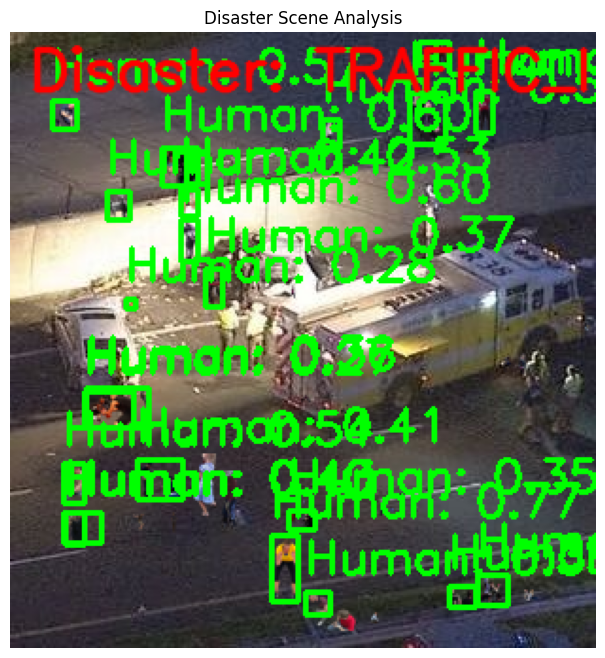

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Initialize the integrated_system object - This part is moved here to fix the NameError
# Check if necessary models and class exist before initialization
if 'yolo_model' in globals() and 'model_classification' in globals() and 'disaster_types' in globals() and 'IntegratedDisasterSystem' in globals():
    integrated_system = IntegratedDisasterSystem(yolo_model, model_classification, disaster_types)
    print("Integrated Disaster System Initialized Successfully for visualization!")
else:
    integrated_system = None
    print("Integrated Disaster System could not be initialized for visualization. Check model loading and IntegratedDisasterSystem class definition.")


def visualize_disaster_analysis(image_path, analysis_report, save_path=None):

    img = cv2.imread(image_path)
    if img is None:
        print(f" Error loading image for visualization: {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img_rgb.shape

    # Draw bounding boxes for detected humans
    detections = analysis_report.get('human_detection', {}).get('detections', [])
    for det in detections:
        bbox = det['bbox']
        confidence = det['confidence']
        x1, y1, x2, y2 = bbox
        # Ensure coordinates are within image bounds
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(width, x2), min(height, y2)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green bounding box
        label = f"Human: {confidence:.2f}"
        cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Add classified disaster type text
    disaster_info = analysis_report.get('disaster_classification', {})
    disaster_type = disaster_info.get('type', 'Unknown')
    disaster_confidence = disaster_info.get('confidence', 0.0)

    disaster_text = f"Disaster: {disaster_type.upper()} ({disaster_confidence:.2f})"
    cv2.putText(img_rgb, disaster_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA) # Red text

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title("Disaster Scene Analysis")
    plt.axis('off')
    plt.show() # Add this line to display the plot

    # Save the visualized image
    if save_path:

        cv2.imwrite(save_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        print(f" Visualized analysis saved to: {save_path}")

# Path to the test images folder
test_images_folder = '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images'

# List image files (case-insensitive match on common image formats)
image_files = [f for f in os.listdir(test_images_folder)
               if f.lower().endswith('.png')]
print(f"Found {len(image_files)} images in the test folder.")
print(f"Image files: {image_files[:5]}...")  # Display first 5 files for brevity

if not image_files:
    print("No images found in the specified test images folder!")
else:
    # Pick a random image
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(test_images_folder, random_image_file)
    random_image_path = random_image_path.replace("\\", "/")
    image_path = random_image_path
    print(f"Selected random image: {image_path}")

# Function to visualize the disaster analysis report
    # integrated_system = IntegratedDisasterSystem(yolo_model = model, classification_model = model_classification, classification_class_names = disaster_types)

    if integrated_system is not None:
      analysis_report = integrated_system.analyze_scene(image_path)
      visualize_disaster_analysis(random_image_path, analysis_report)
    else:
      print("\nSkipping visualization as integrated_system could not be initialized.")

## Refine and save models

### Subtask:
Save the trained YOLO human detection model and the Keras disaster type classification model in a deployable format (e.g., TensorFlow SavedModel, ONNX, or a format suitable for a specific deployment platform).


In [ ]:
import os

# Define paths to save the models
yolo_save_path = '/content/drive/MyDrive/yolov8n_human_detection.pt' # YOLOv8 native format
classification_save_path = '/content/drive/MyDrive/resnet50v2_disaster_classification_savedmodel.h5' # TensorFlow SavedModel format

# 1. Save the trained YOLO model
try:
    model.save(yolo_save_path)
    print(f"YOLO human detection model saved to: {yolo_save_path}")
except Exception as e:
    print(f"Error saving YOLO model: {e}")


# 2. Save the trained Keras classification model in TensorFlow SavedModel format
try:
    model_classification.save(classification_save_path)
    print(f"Keras disaster classification model saved to: {classification_save_path}")
except Exception as e:
    print(f"Error saving Keras classification model: {e}")


YOLO human detection model saved to: /content/drive/MyDrive/yolov8n_human_detection.pt
Keras disaster classification model saved to: /content/drive/MyDrive/resnet50v2_disaster_classification_savedmodel.h5


## Batch Processing and Area Summary

### Subtask:
Create a function to process multiple images from a folder and provide a summary analysis for the entire area.

 PROCESSING DISASTER AREA: /content/c2a_dataset/C2A_Dataset/new_dataset3/test/images
Processing 5 randomly selected images as requested.
Found 5 images to process.

--- Processing Image 1/5: flood_image0310_4.png ---

--- Analyzing Scene: flood_image0310_4.png ---
 Classified Disaster Type: FLOOD (Confidence: 1.00)
Humans Detected: 19
 Human Density Category: High Density
Recommended Resources:
   1. Multiple water rescue teams (boats/helicopters)
   2. Medical triage setup
   3. Temporary shelters
   4. Food and water supplies
   5. Evacuation plans


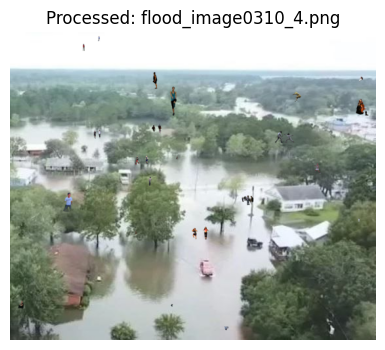


--- Processing Image 2/5: fire_image0251_3.png ---

--- Analyzing Scene: fire_image0251_3.png ---
 Classified Disaster Type: FIRE (Confidence: 1.00)
Humans Detected: 24
 Human Density Category: High Density
Recommended Resources:
   1. Multiple firefighting units (regional support)
   2. Medical triage setup
   3. Temporary shelters
   4. Evacuation plans


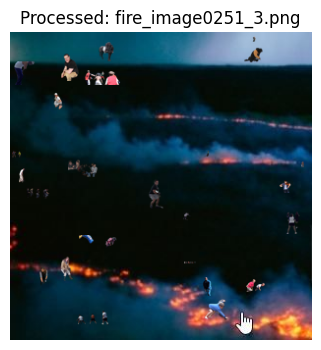


--- Processing Image 3/5: flood_image0274_3.png ---

--- Analyzing Scene: flood_image0274_3.png ---
 Classified Disaster Type: TRAFFIC_INCIDENT (Confidence: 0.61)
Humans Detected: 32
 Human Density Category: High Density
Recommended Resources:
   1. Major incident response team
   2. Medical triage setup
   3. Heavy recovery equipment


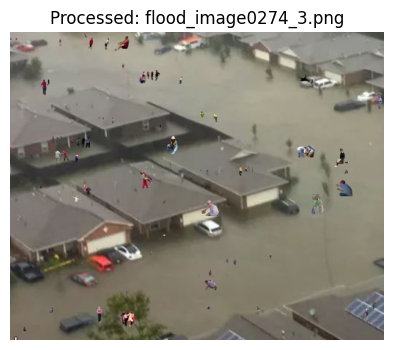


--- Processing Image 4/5: flood_image0481_4.png ---

--- Analyzing Scene: flood_image0481_4.png ---
 Classified Disaster Type: FLOOD (Confidence: 0.98)
Humans Detected: 22
 Human Density Category: High Density
Recommended Resources:
   1. Multiple water rescue teams (boats/helicopters)
   2. Medical triage setup
   3. Temporary shelters
   4. Food and water supplies
   5. Evacuation plans


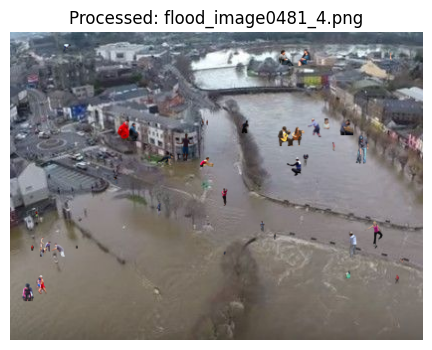


--- Processing Image 5/5: fire_image0452_3.png ---

--- Analyzing Scene: fire_image0452_3.png ---
 Classified Disaster Type: FIRE (Confidence: 0.99)
Humans Detected: 32
 Human Density Category: High Density
Recommended Resources:
   1. Multiple firefighting units (regional support)
   2. Medical triage setup
   3. Temporary shelters
   4. Evacuation plans


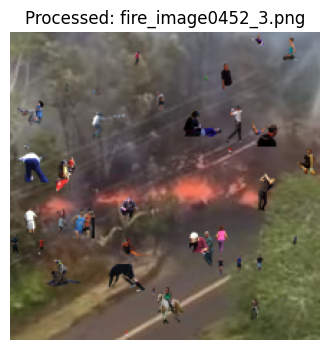

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import random

def process_disaster_area(folder_path, max_images=None):

    print(f" PROCESSING DISASTER AREA: {folder_path}")
    print("=" * 60)

    image_files = []
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            # Check for common image file extensions
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                image_files.append(os.path.join(folder_path, file))
        # image_files.sort() # Removed sorting for random selection

    else:
        print(f" Error: Folder not found at {folder_path}")
        return []

    if not image_files:
        print(f"⚠️ No image files found in {folder_path}")
        return []

    # Shuffle the image files for random selection
    random.shuffle(image_files)

    # Limit the number of images if max_images is specified
    if max_images is not None:
        # Ensure max_images does not exceed the total number of images
        max_images = min(max_images, len(image_files))
        image_files = image_files[:max_images]
        print(f"Processing {len(image_files)} randomly selected images as requested.")


    # Process each image
    analysis_reports = []
    print(f"Found {len(image_files)} images to process.")
    for i, img_path in enumerate(image_files):
        print(f"\n--- Processing Image {i+1}/{len(image_files)}: {os.path.basename(img_path)} ---")
        try:
            report = integrated_system.analyze_scene(img_path)
            if report:
                analysis_reports.append(report)
                # Display the image after analysis
                img = cv2.imread(img_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(6, 4))
                    plt.imshow(img_rgb)
                    plt.title(f"Processed: {os.path.basename(img_path)}")
                    plt.axis('off')
                    plt.show()
                else:
                    print(f" Could not load image for display: {os.path.basename(img_path)}")

        except Exception as e:
            print(f" Error processing image {os.path.basename(img_path)}: {e}")





    return analysis_reports

sample_folder_path = '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images'
area_analysis_results = process_disaster_area(sample_folder_path, max_images=5)

# Reuse saved model

Integrated Disaster System Initialized

Analyzing random image: fire_image0372_2.png


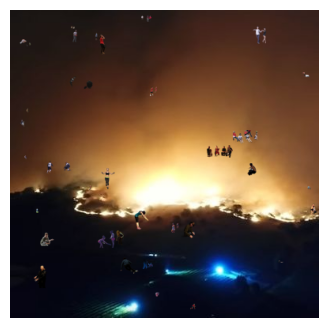


Full report:
{'image_path': '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images/fire_image0372_2.png', 'disaster_classification': {'type': 'fire', 'confidence': 0.9999326467514038}, 'human_detection': {'count': 31, 'detections': [{'bbox': [249, 170, 281, 186], 'confidence': 0.8973238468170166, 'center': [265, 178]}, {'bbox': [306, 20, 324, 42], 'confidence': 0.8054129481315613, 'center': [315, 31]}, {'bbox': [38, 281, 56, 298], 'confidence': 0.7486532926559448, 'center': [47, 290]}, {'bbox': [46, 191, 76, 206], 'confidence': 0.7423810958862305, 'center': [61, 198]}, {'bbox': [281, 151, 313, 168], 'confidence': 0.7058531641960144, 'center': [297, 159]}, {'bbox': [114, 199, 134, 227], 'confidence': 0.6624852418899536, 'center': [124, 213]}, {'bbox': [165, 6, 179, 14], 'confidence': 0.6517915725708008, 'center': [172, 10]}, {'bbox': [226, 371, 234, 378], 'confidence': 0.6381654143333435, 'center': [230, 375]}, {'bbox': [300, 193, 311, 209], 'confidence': 0.6192333698272705, 'cente

In [16]:
#from disaster_system import IntegratedDisasterSystem

from ultralytics import YOLO
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np

YOLO_MODEL_PATH = '/content/drive/MyDrive/yolov8n_human_detection.pt'
CLASSIFICATION_MODEL_PATH = '/content/drive/MyDrive/resnet50v2_disaster_classification_savedmodel.h5'

# Load models
yolo_model = YOLO(YOLO_MODEL_PATH)
classification_model = tf.keras.models.load_model(CLASSIFICATION_MODEL_PATH)

disaster_types = ['collapsed_building', 'flood', 'fire', 'traffic_incident']


if yolo_model is not None and classification_model is not None:
    integrated_system = IntegratedDisasterSystem(yolo_model, classification_model, disaster_types)
else:
    integrated_system = None
    print("Integrated Disaster System could not be initialized due to model loading errors.")
if integrated_system:
    image_folder = '/content/c2a_dataset/C2A_Dataset/new_dataset3/test/images'
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]

    if not image_files:
        print("No images found in the folder!")
    else:
        # Choose a random image to analyze:
        random_image = random.choice(image_files)
        image_path = os.path.join(image_folder, random_image)
        print(f"\nAnalyzing random image: {random_image}")
        plt.figure(figsize=(6, 4))
        plt.imshow(plt.imread(image_path))
        plt.axis('off')
        plt.show()
        report = integrated_system.analyze_scene(image_path)
        print("\nFull report:")
        print(report)


# Task
Deploy the trained YOLO human detection model and the Keras disaster type classification model.

## Deploy and test (Flask Application)

### Subtask:
Deploy the Flask application (e.g., using ngrok in Colab for testing, or to a cloud platform) and test it with new disaster images to ensure it functions correctly and provides timely recommendations.

In [18]:
!pip install Flask --ignore-installed
!pip install flask-ngrok
!pip install pyngrok # Install pyngrok

import os
import tempfile
from flask import Flask, request, jsonify, render_template_string
# from flask_ngrok import run_with_ngrok # We will use pyngrok directly
import tensorflow as tf
from ultralytics import YOLO
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
import base64
from pyngrok import ngrok
from google.colab import userdata # Import userdata to access secrets

# Rescue resource recommendations
RESCUE_RESOURCES = {
    'collapsed_building': {
        'no_humans': ['Search and rescue dogs', 'Structural assessment team', 'Heavy equipment'],
        'low_density': ['Ground rescue teams (small)', 'Medical aid (basic)', 'Search and rescue dogs'],
        'medium_density': ['Ground rescue teams (multiple)', 'Medical aid (advanced)', 'Temporary shelter assessment'],
        'high_density': ['Multiple rescue teams (heavy urban search and rescue)', 'Medical triage setup', 'Temporary shelters', 'Food and water supplies']
    },
    'flood': {
        'no_humans': ['Flood damage assessment', 'Infrastructure check'],
        'low_density': ['Water rescue team (small boat)', 'Medical aid (basic)', 'Evacuation route assessment'],
        'medium_density': ['Water rescue teams (multiple boats)', 'Medical aid (advanced)', 'Evacuation support', 'Temporary shelters'],
        'high_density': ['Multiple water rescue teams (boats/helicopters)', 'Medical triage setup', 'Temporary shelters', 'Food and water supplies', 'Evacuation plans']
    },
    'fire': {
        'no_humans': ['Fire damage assessment', 'Safety perimeter setup'],
        'low_density': ['Firefighting units (local)', 'Medical aid (basic)'],
        'medium_density': ['Firefighting units (multiple)', 'Medical aid (advanced)', 'Evacuation route assessment'],
        'high_density': ['Multiple firefighting units (regional support)', 'Medical triage setup', 'Temporary shelters', 'Evacuation plans']
    },
    'traffic_incident': {
        'no_humans': ['Traffic management', 'Scene cleanup'],
        'low_density': ['Police/Emergency medical (basic)', 'Tow trucks'],
        'medium_density': ['Multiple police/emergency medical', 'Traffic management', 'Accident investigation'],
        'high_density': ['Major incident response team', 'Medical triage setup', 'Heavy recovery equipment']
    },
    'other': {
        'no_humans': ['General assessment team'],
        'low_density': ['Basic rescue team', 'Medical aid (basic)'],
        'medium_density': ['Multiple rescue teams', 'Medical aid (advanced)'],
        'high_density': ['Major rescue operations', 'Medical triage setup']
    }
}

# Integrated Disaster System Class
class IntegratedDisasterSystem:
    def __init__(self, yolo_model, classification_model, classification_class_names):
        self.yolo_model = yolo_model
        self.classification_model = classification_model
        self.classification_class_names = classification_class_names
        print("Integrated Disaster System Initialized")

    def classify_disaster_type(self, image_path):
        """Classify the type of disaster in the image"""
        img = keras_image.load_img(image_path, target_size=(self.classification_model.input_shape[1], self.classification_model.input_shape[2]))
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        # Assume resnet-style preprocessing
        img_array = resnet_preprocess_input(img_array)
        predictions = self.classification_model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = self.classification_class_names[predicted_class_index]
        confidence = np.max(predictions[0])
        return predicted_class_name, float(confidence)

    def detect_humans(self, image_path):
        """Detect humans in disaster scene using YOLO model"""
        results = self.yolo_model(image_path, conf=0.25, verbose=False)
        detections = []
        human_count = 0
        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    # 'human' assumed class 0 in YOLO
                    if box.cls[0] == 0:
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        conf = box.conf[0].cpu().numpy()
                        detections.append({
                            'bbox': [int(x1), int(y1), int(x2), int(y2)],
                            'confidence': float(conf),
                            'center': [int((x1+x2)/2), int((y1+y2)/2)]
                        })
                        human_count += 1
        return detections, human_count

    def assess_human_density(self, human_count):
        """Assess human density category"""
        if human_count == 0:
            return 'no_humans'
        elif human_count <= 2:
            return 'low_density'
        elif human_count <= 5:
            return 'medium_density'
        else:
            return 'high_density'

    def recommend_resources(self, disaster_type, human_density_category):
        """Recommend resources based on disaster type and human density"""
        disaster_key = disaster_type.lower() if disaster_type.lower() in RESCUE_RESOURCES else 'other'
        density_key = human_density_category.lower() if human_density_category.lower() in RESCUE_RESOURCES[disaster_key] else 'no_humans'
        return RESCUE_RESOURCES[disaster_key][density_key]

    def analyze_scene(self, image_path):
        """Analyze a single disaster scene and provide recommendations"""
        print(f"\n--- Analyzing Scene: {os.path.basename(image_path)} ---")
        disaster_type, type_confidence = self.classify_disaster_type(image_path)
        print(f" Classified Disaster Type: {disaster_type.upper()} (Confidence: {type_confidence:.2f})")
        detections, human_count = self.detect_humans(image_path)
        print(f"Humans Detected: {human_count}")
        human_density_category = self.assess_human_density(human_count)
        print(f" Human Density Category: {human_density_category.replace('_', ' ').title()}")
        recommended_resources = self.recommend_resources(disaster_type, human_density_category)
        print("Recommended Resources:")
        for i, resource in enumerate(recommended_resources, 1):
            print(f"   {i}. {resource}")
        image_base64 = None
        try:
            with open(image_path, "rb") as img_file:
                image_base64 = base64.b64encode(img_file.read()).decode('utf-8')
        except Exception as e:
            print(f"Error encoding image to base64: {e}")
        report = {
            'image_path': image_path,
            'disaster_classification': {'type': disaster_type, 'confidence': type_confidence},
            'human_detection': {'count': human_count, 'detections': detections},
            'human_density_category': human_density_category,
            'recommended_resources': recommended_resources,
            'image_base64': image_base64
        }
        return report

# Model Loading Paths
YOLO_MODEL_PATH = r"/content/drive/MyDrive/yolov8n_human_detection.pt"
CLASSIFICATION_MODEL_PATH = r"/content/drive/MyDrive/resnet50v2_disaster_classification_savedmodel.h5"

# Load YOLO model
try:
    yolo_model = YOLO(YOLO_MODEL_PATH)
except Exception as e:
    print(f"Failed to load YOLO model: {e}")
    yolo_model = None

# Load classification model
try:
    classification_model = tf.keras.models.load_model(CLASSIFICATION_MODEL_PATH)
except Exception as e:
    print(f"Failed to load classification model: {e}")
    classification_model = None

disaster_types = ['collapsed_building', 'flood', 'fire', 'traffic_incident']

if yolo_model and classification_model:
    integrated_system = IntegratedDisasterSystem(yolo_model, classification_model, disaster_types)
else:
    integrated_system = None

# Flask App Setup
app = Flask(__name__)
# run_with_ngrok(app, port=5000) # Comment out flask_ngrok's run function

UPLOAD_HTML = """
<!doctype html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Disaster Image Analysis</title>
  <style>
    body {
      background: linear-gradient(135deg, #89f7fe 0%, #66a6ff 100%);
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      color: #222;
      margin: 40px auto;
      max-width: 700px;
      padding: 20px;
      border-radius: 15px;
      box-shadow: 0 8px 16px rgba(0,0,0,0.3);
      background-color: white;
    }
    h1 {
      color: #0056b3;
      text-align: center;
      margin-bottom: 30px;
    }
    form {
      display: flex;
      flex-direction: column;
      align-items: center;
      margin-bottom: 30px;
    }
    input[type="file"] {
      padding: 10px;
      border: 2px dashed #0056b3;
      border-radius: 10px;
      width: 90%;
      max-width: 350px;
      margin-bottom: 15px;
      cursor: pointer;
      transition: border-color 0.3s ease;
    }
    input[type="file"]:hover {
      border-color: #003d75;
    }
    input[type="submit"] {
      background-color: #0056b3;
      color: white;
      font-weight: bold;
      border: none;
      border-radius: 10px;
      padding: 12px 25px;
      cursor: pointer;
      transition: background-color 0.3s ease;
    }
    input[type="submit"]:hover {
      background-color: #003d75;
    }
    .result {
      background-color: #f0f7ff;
      border: 2px solid #66a6ff;
      border-radius: 10px;
      padding: 20px;
      white-space: pre-wrap;
      font-family: 'Courier New', Courier, monospace;
      font-size: 1rem;
      color: #003d75;
    }
    .result h2 {
      color: #0056b3;
      text-align: center;
      margin-bottom: 20px;
    }
    .line {
      margin-bottom: 10px;
      padding-left: 10px;
      border-left: 3px solid #0056b3;
    }
    img.uploaded-image {
      max-width: 100%;
      height: auto;
      border-radius: 10px;
      display: block;
      margin: 20px auto;
      box-shadow: 0 4px 12px rgba(0,0,0,0.15);
    }
  </style>
</head>
<body>
  <h1>Upload an image for disaster analysis</h1>
  <form method="post" enctype="multipart/form-data">
    <input type="file" name="image" accept="image/png, image/jpeg">
    <input type="submit" value="Analyze">
  </form>

  {% if result_lines %}
  <div class="result">
    <h2>Result</h2>
    {% for line in result_lines %}
      <div class="line">{{ line }}</div>
    {% endfor %}
  </div>
  {% endif %}

  {% if image_base64 %}
  <img class="uploaded-image" src="data:image/png;base64,{{ image_base64 }}" alt="Uploaded Image" />
  {% endif %}
</body>
</html>
"""

@app.route('/', methods=['GET'])
def home():
    return '<a href="/upload">Go to interactive disaster analysis page</a>'

@app.route('/upload', methods=['GET', 'POST'])
def upload_page():
    result_lines = None
    image_base64 = None
    temp_path = None
    if request.method == 'POST':
        if 'image' not in request.files or request.files['image'].filename == '':
            result_lines = ["No file selected!"]
        else:
            file = request.files['image']
            try:
                with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as temp:
                    temp_path = temp.name
                    file.save(temp_path)
                if integrated_system:
                    report = integrated_system.analyze_scene(temp_path)
                    result_lines = [
                        f"Disaster Type: {report['disaster_classification']['type']} (Confidence: {report['disaster_classification']['confidence']:.2f})",
                        f"Human Count: {report['human_detection']['count']}",
                        f"Human Density Category: {report['human_density_category'].replace('_', ' ').title()}",
                        "Resource Recommendations:"
                    ] + [f"  - {res}" for res in report['recommended_resources']]
                    image_base64 = report.get('image_base64', None)
                else:
                    result_lines = ["System not initialized."]
            except Exception as ex:
                result_lines = [f"Analysis failed. {ex}"]
            finally:
                if temp_path and os.path.exists(temp_path):
                    os.remove(temp_path)
    return render_template_string(UPLOAD_HTML, result_lines=result_lines, image_base64=image_base64)

@app.route('/analyze', methods=['POST'])
def analyze_image():
    temp_path = None
    if integrated_system is None:
        return jsonify({"error": "System not initialized properly."}), 500
    if 'image' not in request.files:
        return jsonify({"error": "No image file provided."}), 400
    file = request.files['image']
    if file.filename == '':
        return jsonify({"error": "No selected file."}), 400
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as temp:
            temp_path = temp.name
            file.save(temp_path)
        report = integrated_system.analyze_scene(temp_path)
        return jsonify(report), 200
    except Exception as ex:
        return jsonify({"error": "Analysis failed.", "details": str(ex)}), 500
    finally:
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)

if __name__ == '__main__':
    # Get the ngrok authtoken from Colab secrets
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    if NGROK_AUTH_TOKEN:
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
        print("ngrok authtoken configured.")
    else:
        print("ngrok authtoken not found in Colab secrets. Please add it as NGROK_AUTH_TOKEN.")
        # Exit if auth token is not found
        exit() # Add exit here to stop execution if token is missing

    # Start ngrok tunnel
    try:
        # Disconnect any existing tunnels before starting a new one
        ngrok.disconnect(ngrok.get_public_url()) # Attempt to disconnect existing tunnels
        public_url = ngrok.connect(5000).public_url
        print(f" * ngrok tunnel established at {public_url}")
    except Exception as e:
        print(f"Failed to start ngrok tunnel: {e}")
        public_url = None

    # Run the Flask app
    if public_url: # Only run Flask if ngrok tunnel is established
        app.run(host='0.0.0.0', port=5000)
    else:
        print("Flask app not started because ngrok tunnel could not be established.")

  Using cached flask-3.1.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
Using cached flask-3.1.1-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.2.1-py3-none-any.whl (102 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)


Integrated Disaster System Initialized


SecretNotFoundError: Secret NGROK_AUTH_TOKEN does not exist.